# Analysis of non-cycling microglia from experiment 2

This notebook generates major results in Figures S4 and S9 for the non-cycling microglia from Experiment 2 (with transcription and translation inhibitors).

# Preparation

This list includes the necessary packages to run the notebook, along with some that may not be required here but are commonly used for exploring adata.

In [103]:
import os
import re
import time
import glob
import csv
import seqc
import h5py
import tables
import seqc.filter
import warnings
import itertools
import harmony
import palantir as pl
import scvelo as scv
import cellrank as cr
import collections
import statsmodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import doubletdetection
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc
import seaborn as sns
import scrublet as scr
import anndata as ad
import networkx as nx
import logging
import scipy.cluster.hierarchy as shc
import scanpy.external as sce
import logging

from pathlib import Path
from typing import Dict
from scipy import sparse
from scipy import io
from scipy.sparse.csgraph import connected_components
from sklearn.preprocessing import normalize
from itertools import compress
from kneed import KneeLocator
from copy import deepcopy
from seqc import plot
from seqc.plot import FigureGrid
from collections import OrderedDict
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from seqc.sparse_frame import SparseFrame
from scipy.io import mmwrite
from adjustText import adjust_text

In [104]:
# Define and customize plot attributes
%matplotlib inline
sc.set_figure_params(dpi=80) 

sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = [4,4]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.style.use("ggplot")
mpl.rcdefaults()
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Initialize

In [105]:
# Change directory to the desired path:
DATA_DIR = '/data/massague/gans/projects/Breast_tumor/GitHub/Data/'

# Sub-directory for the data of non-cycling microglia from experiment 1 
source = 'Non_Cycling_MG_2/'

# Processed adata
for h5_file in Path(DATA_DIR+source).glob('*.h5'):    
    adata = sc.read(h5_file) # Log-transformed, normalized data

## Load MILO results

### Neighborhood indexes and cell counts

In [107]:
# Directory for the Milo results
MILO_DIR = DATA_DIR+source+'Milo/'

# 'Added' in the file name indicates that transcription and translation inhibitors are added:
nhoodIdx = (pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_Added_milo.nhoodIndex.csv', index_col=0)-1).T

# Each row in column "1": the index cell per Milo neighborhood
nhoodIdx

,1
X276,275
X10,9
X220,219
X469,468
X457,456
...,...
X850,849
X223,222
X369,368
X505,504


In [108]:
nhoodCounts = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_Added_milo.nhoodCounts.csv', index_col=0)

# Number of cells from each source per neighborhood
nhoodCounts 

,HER2BC_Unlabeled_inhib_added,TNBC_Unlabeled_inhib_added,HER2BC_Labeled_inhib_added,TNBC_Labeled_inhib_added
1,2,0,83,7
2,19,4,59,28
3,2,0,102,34
4,2,2,4,83
5,5,0,16,19
...,...,...,...,...
94,7,0,39,41
95,2,0,59,11
96,4,1,55,3
97,0,0,22,6


In [111]:
# Update row names in the above Milo results to match the corresponding obs_names of adata
nhoodIdx.index = adata.obs_names[nhoodIdx][:,0]
nhoodCounts.index = nhoodIdx.index

### Generalized linear model (GLM) fit results

In [112]:
fit = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_Added_milo.nhoodCountsFit.csv', index_col=0)
fit.index = nhoodIdx.index
fit

,(Intercept),groupHER2BC_Labeled_inhib_added,groupTNBC_Labeled_inhib_added
SG-602_d27_inh_mCh_135485209929588-1-1,-1.729433,3.987137,1.608689
SG-602_d27_inh_neg_130673819466478-0-1,0.607038,1.310111,0.643522
SG-602_d27_inh_mCh_226764285697389-1-1,-1.731585,4.195079,3.175413
SG-602_d27_inh_mCh_196166683318059-1-1,-1.003473,0.264305,3.337328
SG-602_d27_inh_mCh_130615971375461-1-1,-0.897156,1.516279,1.762333
...,...,...,...
SG-602_d27_inh_mCh_134585729080052-1-1,-0.591851,2.096349,2.222182
SG-602_d27_inh_mCh_134393214979310-1-1,-1.726823,3.643972,2.050825
SG-602_d27_inh_mCh_230731478350238-1-1,-0.856314,2.703447,-0.085621
SG-602_d27_inh_mCh_155911403785638-1-1,-4.040902,4.975894,3.769309


In [113]:
# Add UMAP embedding results to assist downstream visualization
fit.loc[:,['UMAP_1','UMAP_2']] = adata[fit.index].obsm['X_umap']
fit

,(Intercept),groupHER2BC_Labeled_inhib_added,groupTNBC_Labeled_inhib_added,UMAP_1,UMAP_2
SG-602_d27_inh_mCh_135485209929588-1-1,-1.729433,3.987137,1.608689,-0.079485,11.972305
SG-602_d27_inh_neg_130673819466478-0-1,0.607038,1.310111,0.643522,-2.650119,8.886947
SG-602_d27_inh_mCh_226764285697389-1-1,-1.731585,4.195079,3.175413,-0.174918,10.571673
SG-602_d27_inh_mCh_196166683318059-1-1,-1.003473,0.264305,3.337328,-0.950216,8.789554
SG-602_d27_inh_mCh_130615971375461-1-1,-0.897156,1.516279,1.762333,-1.186834,9.583997
...,...,...,...,...,...
SG-602_d27_inh_mCh_134585729080052-1-1,-0.591851,2.096349,2.222182,-2.918331,9.828162
SG-602_d27_inh_mCh_134393214979310-1-1,-1.726823,3.643972,2.050825,-0.203613,10.934850
SG-602_d27_inh_mCh_230731478350238-1-1,-0.856314,2.703447,-0.085621,0.475712,11.051462
SG-602_d27_inh_mCh_155911403785638-1-1,-4.040902,4.975894,3.769309,-0.708511,10.754683


In [115]:
# Note the fit results have also been added to the adata provided, using: 
adata.obs['GLM_coeff_HER2BC_Labeled'] = np.nan
adata.obs['GLM_coeff_TNBC_Labeled'] = np.nan

adata.obs['GLM_coeff_HER2BC_Labeled'][fit.index] = fit.loc[:,'groupHER2BC_Labeled_inhib_added']
adata.obs['GLM_coeff_TNBC_Labeled'][fit.index] = fit.loc[:,'groupTNBC_Labeled_inhib_added']

### Differential abundance results

In [116]:
# da: "differential abundance", saved as a dictionary, with the keys set to the groups compared
da = {}

In [118]:
for k in ['TNvsHER2', 'TNvsCtrl', 'HER2vsCtrl', 'LabeledvsCtrl']:
    
    da[k] = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_Added_milo.da_'+k+'.csv', index_col=0)

    # Note "-1" comes from the fact that index starts from 1 in R and from 0 in Python
    # To match the Milo results obtained in R to Python, need to -1
    da[k].loc[:,'Nhood'] = da[k].index-1

    da[k].index = nhoodIdx.index
    da[k].loc[:,'neg_log10(SpatialFDR)'] = -np.log10(da[k].loc[:,'SpatialFDR'])

    # Total No. of cells in the neighborhood
    da[k].loc[:,'nhood_size'] = nhoodCounts.sum(axis=1).to_numpy()
    
    # Update results to adata
    adata.obs[k+'_neg_log10(SpatialFDR)'] = np.nan
    adata.obs[k+'_neg_log10(SpatialFDR)'][da[k].index] = da[k].loc[:,'neg_log10(SpatialFDR)']
    fit.loc[:,k+'_neg_log10(SpatialFDR)'] = da[k].loc[fit.index,'neg_log10(SpatialFDR)']
    
    if k != 'LabeledvsCtrl':
        adata.obs[k+'_logFC'] = np.nan
        adata.obs[k+'_logFC'][da[k].index] = da[k].loc[:,'logFC']
        fit.loc[:,k+'_logFC'] = da[k].loc[fit.index,'logFC']
        
fit.loc[:,'nhood_size'] = da['TNvsHER2'].loc[fit.index,'nhood_size']
fit

,(Intercept),groupHER2BC_Labeled_inhib_added,groupTNBC_Labeled_inhib_added,UMAP_1,UMAP_2,TNvsHER2_neg_log10(SpatialFDR),TNvsHER2_logFC,TNvsCtrl_neg_log10(SpatialFDR),TNvsCtrl_logFC,HER2vsCtrl_neg_log10(SpatialFDR),HER2vsCtrl_logFC,LabeledvsCtrl_neg_log10(SpatialFDR),nhood_size
SG-602_d27_inh_mCh_135485209929588-1-1,-1.729433,3.987137,1.608689,-0.079485,11.972305,0.252786,-3.431375,0.463218,2.320848,2.123356,5.752222,1.700287,92
SG-602_d27_inh_neg_130673819466478-0-1,0.607038,1.310111,0.643522,-2.650119,8.886947,0.074262,-0.961684,0.177447,0.928407,0.533488,1.890090,0.254205,110
SG-602_d27_inh_mCh_226764285697389-1-1,-1.731585,4.195079,3.175413,-0.174918,10.571673,0.082311,-1.471067,1.109168,4.581153,2.143112,6.052220,1.666960,138
SG-602_d27_inh_mCh_196166683318059-1-1,-1.003473,0.264305,3.337328,-0.950216,8.789554,0.372366,4.433436,1.183905,4.814747,0.070117,0.381311,1.631973,91
SG-602_d27_inh_mCh_130615971375461-1-1,-0.897156,1.516279,1.762333,-1.186834,9.583997,0.019013,0.354981,0.657366,2.542509,0.713559,2.187529,0.588676,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SG-602_d27_inh_mCh_134585729080052-1-1,-0.591851,2.096349,2.222182,-2.918331,9.828162,0.005745,0.181538,0.798567,3.205931,1.028091,3.024392,0.799798,87
SG-602_d27_inh_mCh_134393214979310-1-1,-1.726823,3.643972,2.050825,-0.203613,10.934850,0.179701,-2.298426,0.657366,2.958715,2.068871,5.257140,1.569524,72
SG-602_d27_inh_mCh_230731478350238-1-1,-0.856314,2.703447,-0.085621,0.475712,11.051462,0.372366,-4.023773,0.012054,-0.123524,1.515557,3.900249,1.392760,63
SG-602_d27_inh_mCh_155911403785638-1-1,-4.040902,4.975894,3.769309,-0.708511,10.754683,0.142813,-1.740735,1.080727,5.437963,2.255238,7.178698,1.758189,28


### Adjacency matrix of neighbors

In [119]:
# Number of neighbors: i.e., number of cells shared between different neighborhoods (off-diagonal)
# On the diagonal line, number of cells per neighborhood 

nhoodAdj = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_Added_milo.nhoodIndex.adj.csv', index_col=0)
nhoodAdj

,276,10,220,469,457,304,415,266,306,250,...,1049,920,240,277,521,850,223,369,505,620
276,92,0,0,0,5,4,17,5,4,0,...,0,0,31,8,5,0,21,5,0,0
10,0,110,0,10,4,3,0,0,6,0,...,4,3,0,0,0,3,0,0,0,11
220,0,0,138,0,1,30,55,42,0,5,...,0,0,0,2,0,0,4,11,7,1
469,0,10,0,91,1,5,1,0,6,0,...,0,33,0,0,0,0,0,0,0,25
457,5,4,1,1,40,0,0,0,5,0,...,0,0,1,0,3,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,0,3,0,0,0,0,0,0,2,0,...,1,1,0,0,7,87,0,0,0,12
223,21,0,4,0,0,13,24,21,6,0,...,0,0,10,2,0,0,72,10,2,0
369,5,0,11,0,0,9,16,15,0,1,...,0,0,2,6,0,0,10,63,4,0
505,0,0,7,0,0,8,0,1,0,1,...,0,0,0,0,0,0,2,4,28,0


In [120]:
# Update row and column names to obs_names of the index cells of the neighborhoods 
nhoodAdj.index = nhoodIdx.index
nhoodAdj.columns = nhoodIdx.index
nhoodAdj

,SG-602_d27_inh_mCh_135485209929588-1-1,SG-602_d27_inh_neg_130673819466478-0-1,SG-602_d27_inh_mCh_226764285697389-1-1,SG-602_d27_inh_mCh_196166683318059-1-1,SG-602_d27_inh_mCh_130615971375461-1-1,SG-602_d27_inh_mCh_231145183827877-1-1,SG-602_d27_inh_mCh_161547086321451-1-1,SG-602_d27_inh_mCh_121748858758885-1-1,SG-602_d27_inh_mCh_170328446692062-1-1,SG-602_d27_inh_mCh_227853878324125-1-1,...,SG-602_d27_inh_mCh_235600119479533-1-1,SG-602_d27_inh_mCh_232236087135518-1-1,SG-602_d27_inh_mCh_156515920636340-1-1,SG-602_d27_inh_mCh_226833171401571-1-1,SG-602_d27_inh_mCh_191099042917595-1-1,SG-602_d27_inh_mCh_134585729080052-1-1,SG-602_d27_inh_mCh_134393214979310-1-1,SG-602_d27_inh_mCh_230731478350238-1-1,SG-602_d27_inh_mCh_155911403785638-1-1,SG-602_d27_inh_mCh_120788115144115-1-1
SG-602_d27_inh_mCh_135485209929588-1-1,92,0,0,0,5,4,17,5,4,0,...,0,0,31,8,5,0,21,5,0,0
SG-602_d27_inh_neg_130673819466478-0-1,0,110,0,10,4,3,0,0,6,0,...,4,3,0,0,0,3,0,0,0,11
SG-602_d27_inh_mCh_226764285697389-1-1,0,0,138,0,1,30,55,42,0,5,...,0,0,0,2,0,0,4,11,7,1
SG-602_d27_inh_mCh_196166683318059-1-1,0,10,0,91,1,5,1,0,6,0,...,0,33,0,0,0,0,0,0,0,25
SG-602_d27_inh_mCh_130615971375461-1-1,5,4,1,1,40,0,0,0,5,0,...,0,0,1,0,3,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SG-602_d27_inh_mCh_134585729080052-1-1,0,3,0,0,0,0,0,0,2,0,...,1,1,0,0,7,87,0,0,0,12
SG-602_d27_inh_mCh_134393214979310-1-1,21,0,4,0,0,13,24,21,6,0,...,0,0,10,2,0,0,72,10,2,0
SG-602_d27_inh_mCh_230731478350238-1-1,5,0,11,0,0,9,16,15,0,1,...,0,0,2,6,0,0,10,63,4,0
SG-602_d27_inh_mCh_155911403785638-1-1,0,0,7,0,0,8,0,1,0,1,...,0,0,0,0,0,0,2,4,28,0


# Analysis & Visualization

## Examine the differential sample distribution 

Since many visualization and analysis steps rely on a random number seed, each run may produce slight variations. For consistency in this illustration, we load and use the data as processed in the manuscript.

<b> Sample colors: </b>

1) HER2BC_Labeled
2) TNBC_Unlabeled
3) TNBC_Labeled
4) HER2BC_Unlabeled

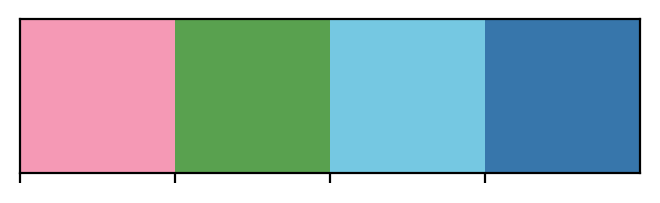

In [121]:
# Reset the colors if needed: 
adata.uns['sample_confirmed_colors'] = ['#F599B5', '#59a14f', '#75C8E2', '#3776ab']
sns.palplot(adata.uns['sample_confirmed_colors'])

<b> Scatter plot </b>

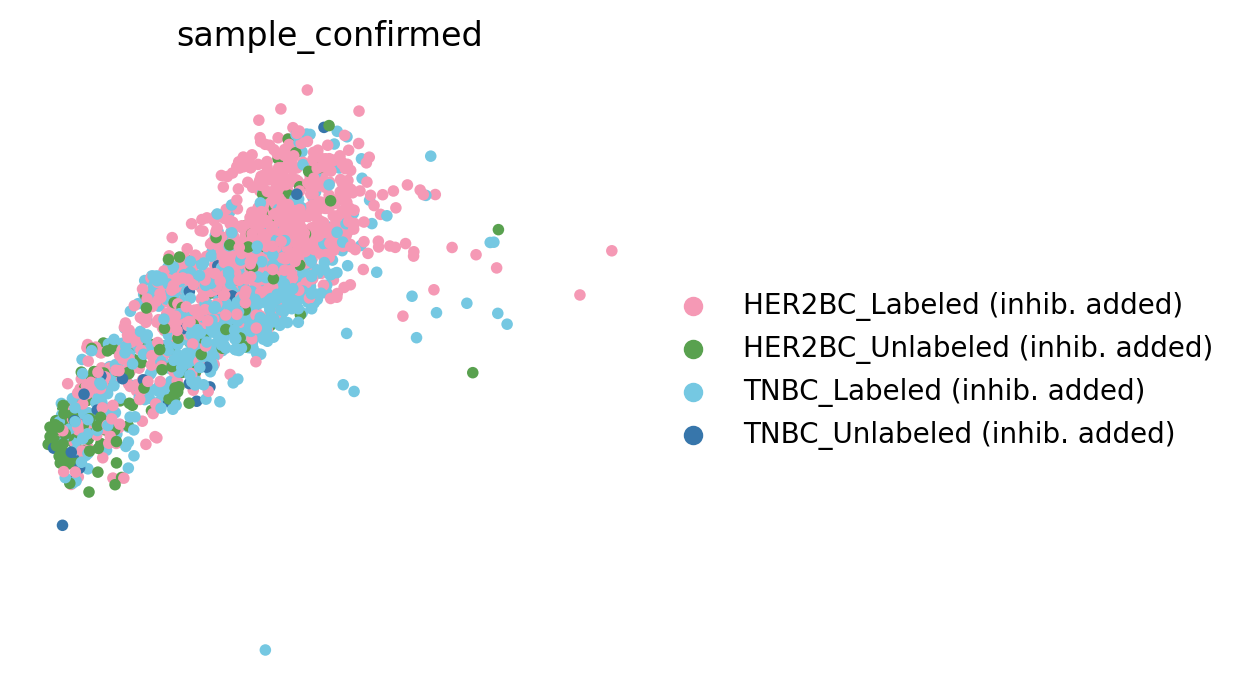

In [122]:
# Randomize the order of data points to plot
vis_rand = np.random.choice(range(adata.shape[0]),replace=False, size=adata.shape[0])

mpl.rcParams['figure.figsize'] = [4,4]
sc.pl.umap(adata[vis_rand],
           color=['sample_confirmed'],
           frameon=False)

<b> Contour plot </b>

In [123]:
# data_plot: UMAP embedding of the cells
data_plot = pd.DataFrame(adata.obsm["X_umap"], 
                         index = adata.obs_names,
                         columns = ["UMAP_1","UMAP_2"])

# "sample_confirmed": the confirmed sources of the cells
data_plot = pd.concat([data_plot, adata.obs["sample_confirmed"]],
                      axis=1).reindex(data_plot.index)

data_plot

,UMAP_1,UMAP_2,sample_confirmed
SG-602_d27_inh_neg_130049285221093-0-1,-0.741143,11.157387,HER2BC_Unlabeled (inhib. added)
SG-602_d27_inh_neg_204342172272540-0-1,-2.771379,10.318529,HER2BC_Unlabeled (inhib. added)
SG-602_d27_inh_neg_170677547219699-0-1,-0.522419,11.058144,HER2BC_Unlabeled (inhib. added)
SG-602_d27_inh_neg_239476046482291-0-1,-0.883057,9.891013,HER2BC_Unlabeled (inhib. added)
SG-602_d27_inh_neg_126278170242356-0-1,-1.040815,10.547717,HER2BC_Unlabeled (inhib. added)
...,...,...,...
SG-602_d27_inh_mCh_164698952756006-1-1,0.023341,12.664145,HER2BC_Labeled (inhib. added)
SG-602_d27_inh_mCh_197280152861043-1-1,-3.260620,6.914677,HER2BC_Labeled (inhib. added)
SG-602_d27_inh_mCh_157604606490917-1-1,0.017037,12.639256,HER2BC_Labeled (inhib. added)
SG-602_d27_inh_mCh_121254238926635-1-1,-0.005783,12.613868,TNBC_Labeled (inhib. added)


<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

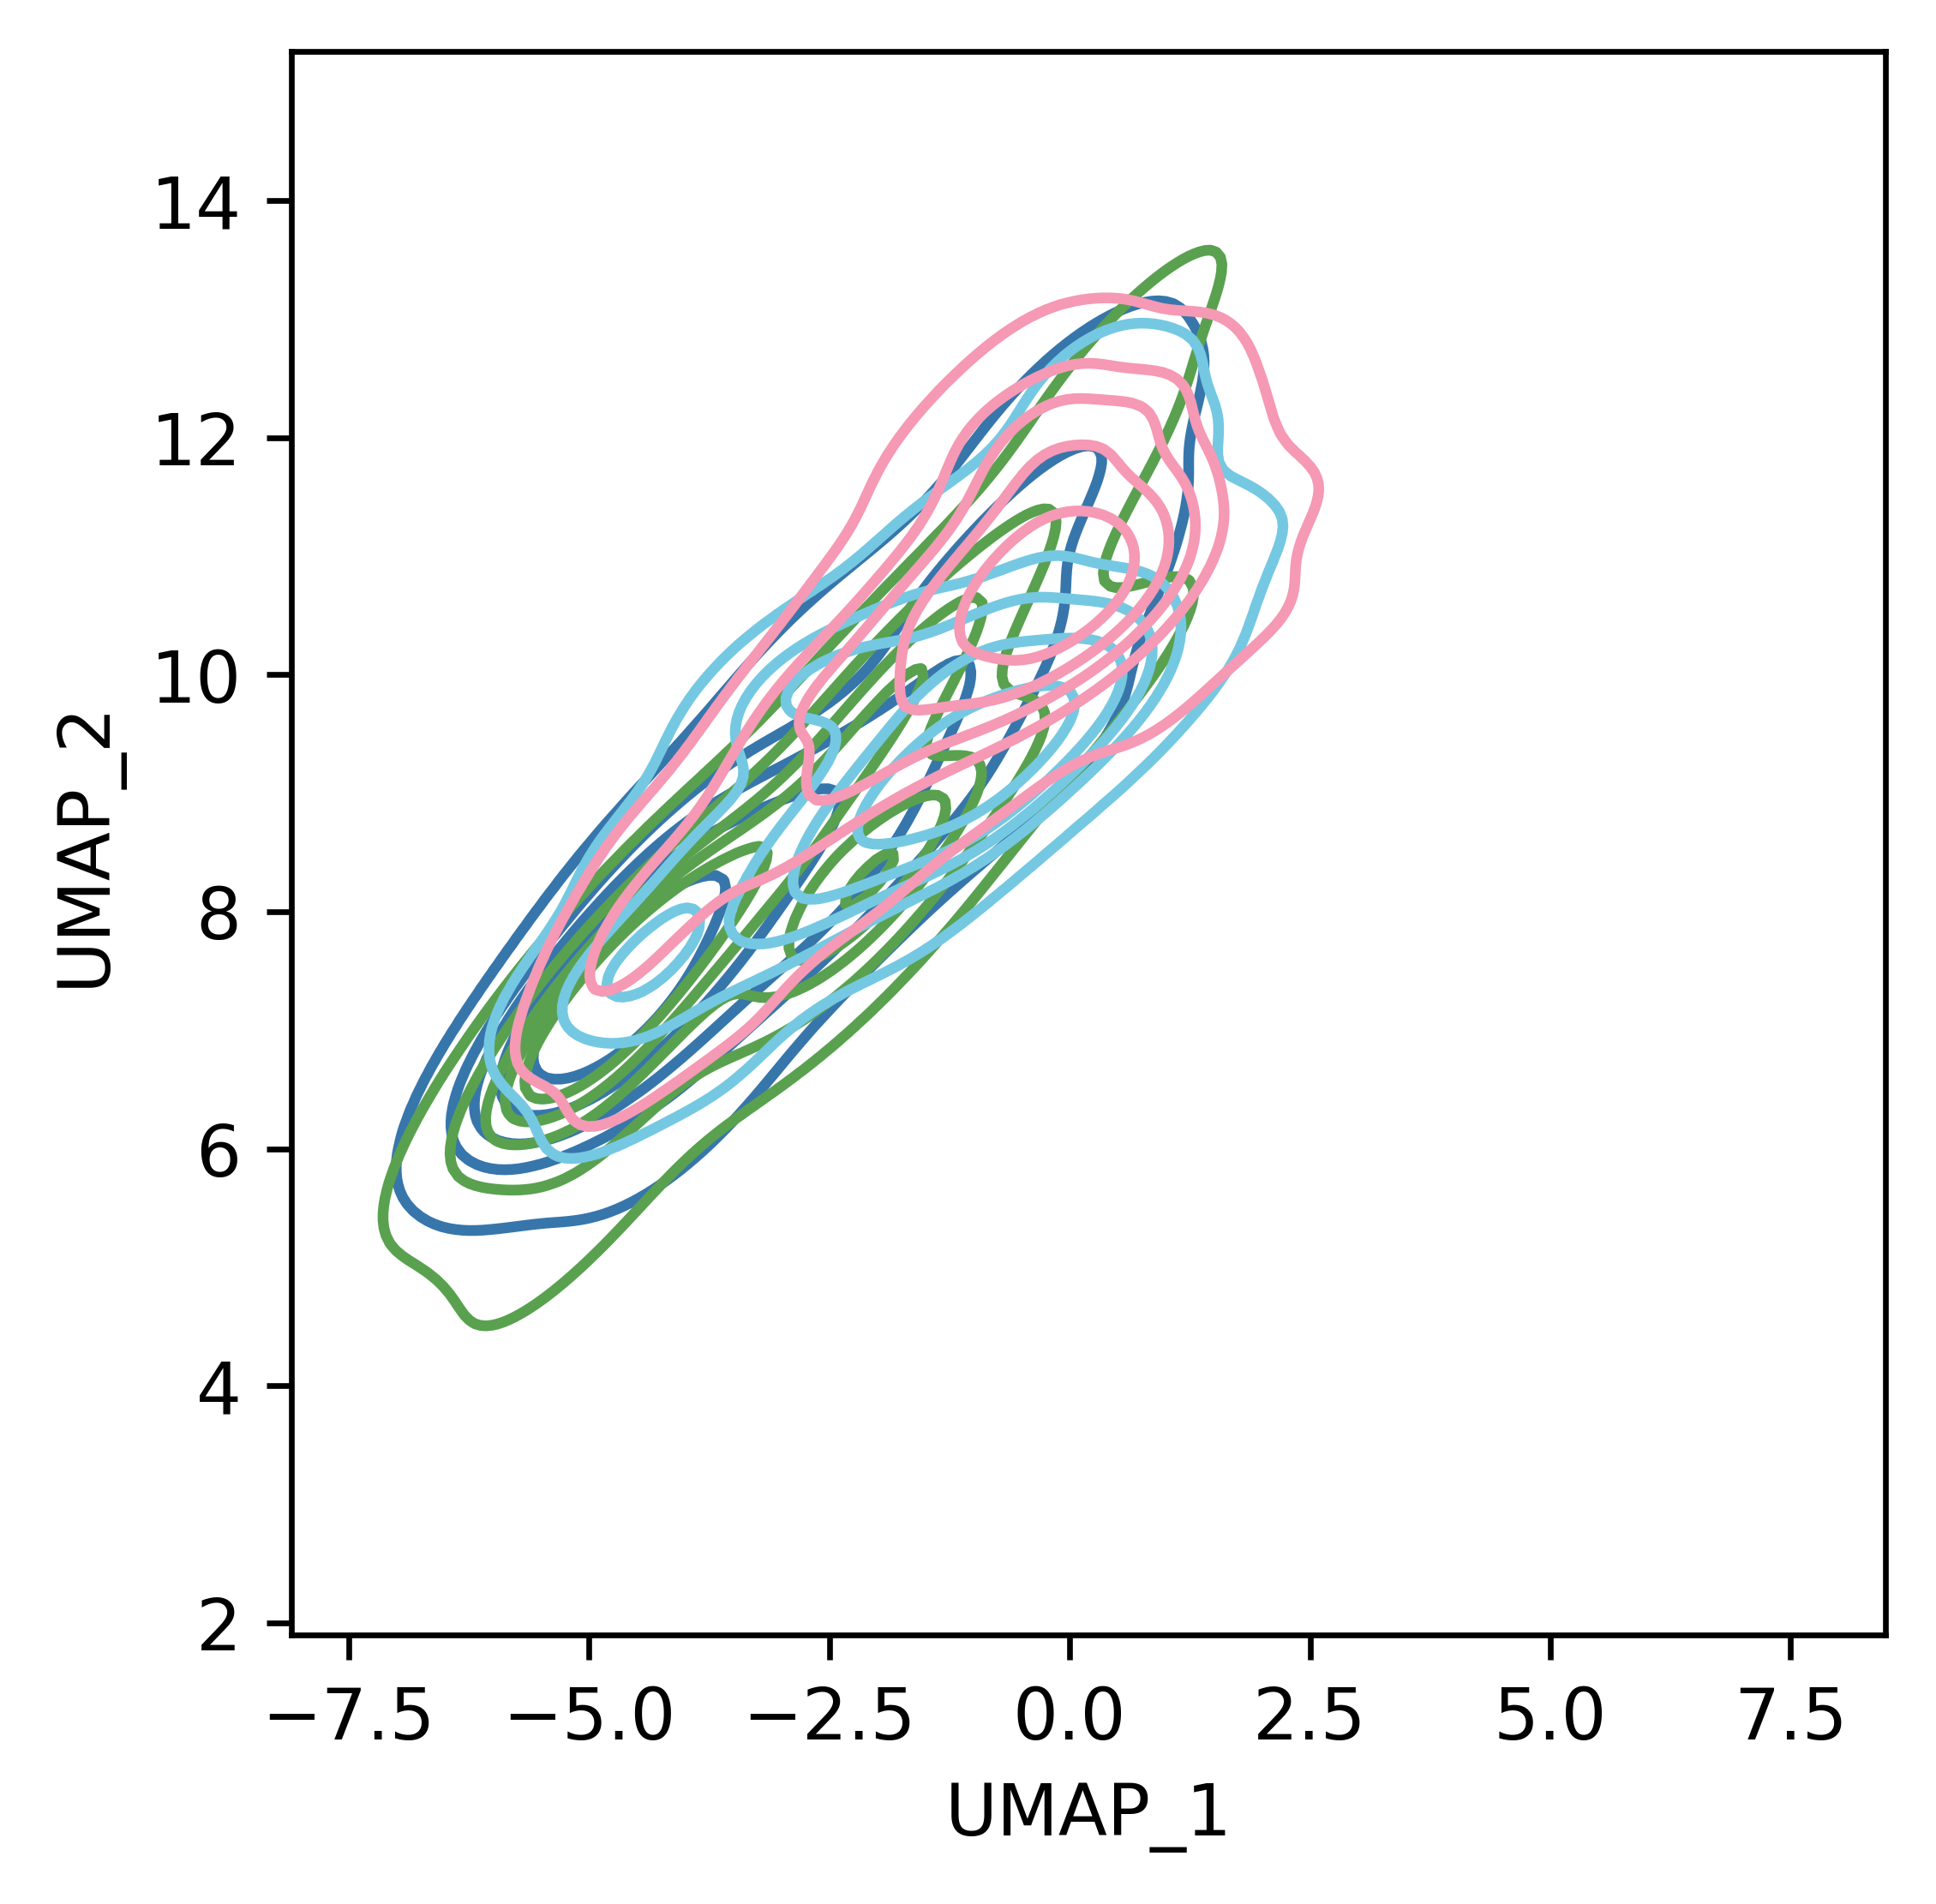

In [140]:
plt.show()

ax = sns.kdeplot(data = data_plot.loc[data_plot['sample_confirmed'] == 'HER2BC_Unlabeled (inhib. added)',:],
            levels=6, x="UMAP_1", y="UMAP_2", label='HER2BC_Unlabeled', color='#3776ab') 

sns.kdeplot(data = data_plot.loc[data_plot['sample_confirmed'] == 'TNBC_Unlabeled (inhib. added)',:],
            levels=6, x="UMAP_1", y="UMAP_2", ax=ax, label='TNBC_Unlabeled', color='#59a14f') 

sns.kdeplot(data = data_plot.loc[data_plot['sample_confirmed'] == 'TNBC_Labeled (inhib. added)',:],
            levels=6, x="UMAP_1", y="UMAP_2", ax=ax, label='TNBC_Labeled', color='#75C8E2')

sns.kdeplot(data = data_plot.loc[data_plot['sample_confirmed'] == 'HER2BC_Labeled (inhib. added)',:],
            levels=6, x="UMAP_1", y="UMAP_2", ax=ax, label='HER2BC_Labeled', color='#F599B5')

## Compute neighborhood-averaged expression

In [127]:
nhood = {} # Store all neighborhoods

for f in Path(MILO_DIR).glob('*milo.nhoodDistances_*'): 
    n = str(f).split('.csv')[0].split('milo.nhoodDistances_')[-1] 
    # neighborhood index cell (in R), need to -1 to convert to Python
    k = nhoodIdx.index[np.where(nhoodIdx == int(n)-1)[0][0]]
    nhood[k] = pd.read_csv(f, index_col=0)

<b> Signature scores </b>

Here is an example of computing the neighborhood-averaged actin remodeling and type I interferon response scores, followed by the visualization of gene expression trends using the scores computed and stored in adata.

In [134]:
k = 'LabeledvsCtrl'

# List of the signatures to compute
score_list = ['Actin_poly_depoly_score','Annotated_TypeI_IFN_score']
da[k].loc[:,['nhood_'+s for s in score_list]] = np.nan

for i in da[k].index:
    
    # All cells in the neighborhood
    l = adata[nhood[i].index].obs_names 

    # Average among the cells and store the results in da 
    da[k].loc[i,['nhood_'+s for s in score_list]] = np.average(adata[l].obs[score_list], axis=0)

In [135]:
da[k].loc[:,['nhood_'+s for s in score_list]]

,nhood_Actin_poly_depoly_score,nhood_Annotated_TypeI_IFN_score
SG-602_d27_inh_mCh_135485209929588-1-1,0.238439,0.294606
SG-602_d27_inh_neg_130673819466478-0-1,0.197160,-0.091216
SG-602_d27_inh_mCh_226764285697389-1-1,0.245948,0.416605
SG-602_d27_inh_mCh_196166683318059-1-1,0.216499,-0.088148
SG-602_d27_inh_mCh_130615971375461-1-1,0.218089,-0.141154
...,...,...
SG-602_d27_inh_mCh_134585729080052-1-1,0.209577,0.440786
SG-602_d27_inh_mCh_134393214979310-1-1,0.249972,0.264820
SG-602_d27_inh_mCh_230731478350238-1-1,0.259272,0.893215
SG-602_d27_inh_mCh_155911403785638-1-1,0.228779,1.390229


<b> Gene expression </b>

Here is an example of computing the neighborhood-averaged LPL, CSF1, CD9, ITGAX, and CCL6 expression, followed by the visualization of gene expression trends using the values computed and stored in adata.

In [149]:
k = 'LabeledvsCtrl'
gene_list = ['LPL','CSF1','CD9','ITGAX','CCL6']

for i in da[k].index:
    # All cells in the neighborhood
    l = adata[nhood[i].index].obs_names 

    da[k].loc[i,['nhood_'+s for s in gene_list]] = np.average(adata[l,:][:,gene_list].X, axis=0)

In [150]:
da[k].loc[:,['nhood_'+s for s in gene_list]]

,nhood_LPL,nhood_CSF1,nhood_CD9,nhood_ITGAX,nhood_CCL6
SG-602_d27_inh_mCh_135485209929588-1-1,0.211054,0.236352,2.290442,0.101577,0.505365
SG-602_d27_inh_neg_130673819466478-0-1,0.321340,0.361693,3.163139,0.700190,0.891527
SG-602_d27_inh_mCh_226764285697389-1-1,0.458740,0.279869,3.364767,0.854159,1.028182
SG-602_d27_inh_mCh_196166683318059-1-1,0.244438,0.343877,2.878213,0.543831,1.110989
SG-602_d27_inh_mCh_130615971375461-1-1,0.342902,0.416755,3.465602,0.419842,0.892492
...,...,...,...,...,...
SG-602_d27_inh_mCh_134585729080052-1-1,0.080115,0.261419,2.186108,0.176381,0.499994
SG-602_d27_inh_mCh_134393214979310-1-1,0.539928,0.242319,3.199864,0.333505,1.051617
SG-602_d27_inh_mCh_230731478350238-1-1,0.322872,0.256279,3.062455,0.541920,0.973521
SG-602_d27_inh_mCh_155911403785638-1-1,0.315194,0.463491,2.798915,0.716322,0.938398


Save the values back to adata for visualization.

In [151]:
adata.obs[['nhood_'+s for s in gene_list]] = np.nan

for s in gene_list:
    adata.obs['nhood_'+s][da[k].index] = da[k].loc[:,'nhood_'+s].copy()    

## Compute diffusion components

Here're the example codes, while the following visualization uses the original results computed and stored in adata.

In [136]:
# adata.uns['pca']['no_pcs']: Number of PCs to use to compute diffusion components
dm = pl.utils.run_diffusion_maps(pd.DataFrame(adata.obsm['X_pca'][:,0:adata.uns['pca']['no_pcs']]), 
                                 knn=30, n_components=20)

adata.obsm['X_dm'] = np.array(dm['EigenVectors'])

Determing nearest neighbor graph...


In [137]:
dm_uns = OrderedDict()
dm_uns['adjacency'] = dm['kernel']
dm_uns['eigenvalues'] = dm['EigenValues'].values
dm_uns['T'] = dm['T'] # transition matrix

# Store the data in diffusion component results in adata 
adata.uns['dm'] = dm_uns 

In [138]:
dc = [1,2,3,4,5]
adata.obs[['Microglia_X_dm_'+str(i) for i in dc]] = np.nan

for i in dc:
    # Store the non-trivial components start from 1 
    adata.obs['Microglia_X_dm_'+str(i)][adata.obs_names] = \
    adata.obsm['X_dm'][:,i]

<b> First diffusion component (DC1) </b>


Note that DC1 decreases along the axis of the homeostasis-to-DAM transition. However, since the sign of this value is arbitrary, we reverse its order later to facilitate the visualization of expression trends.

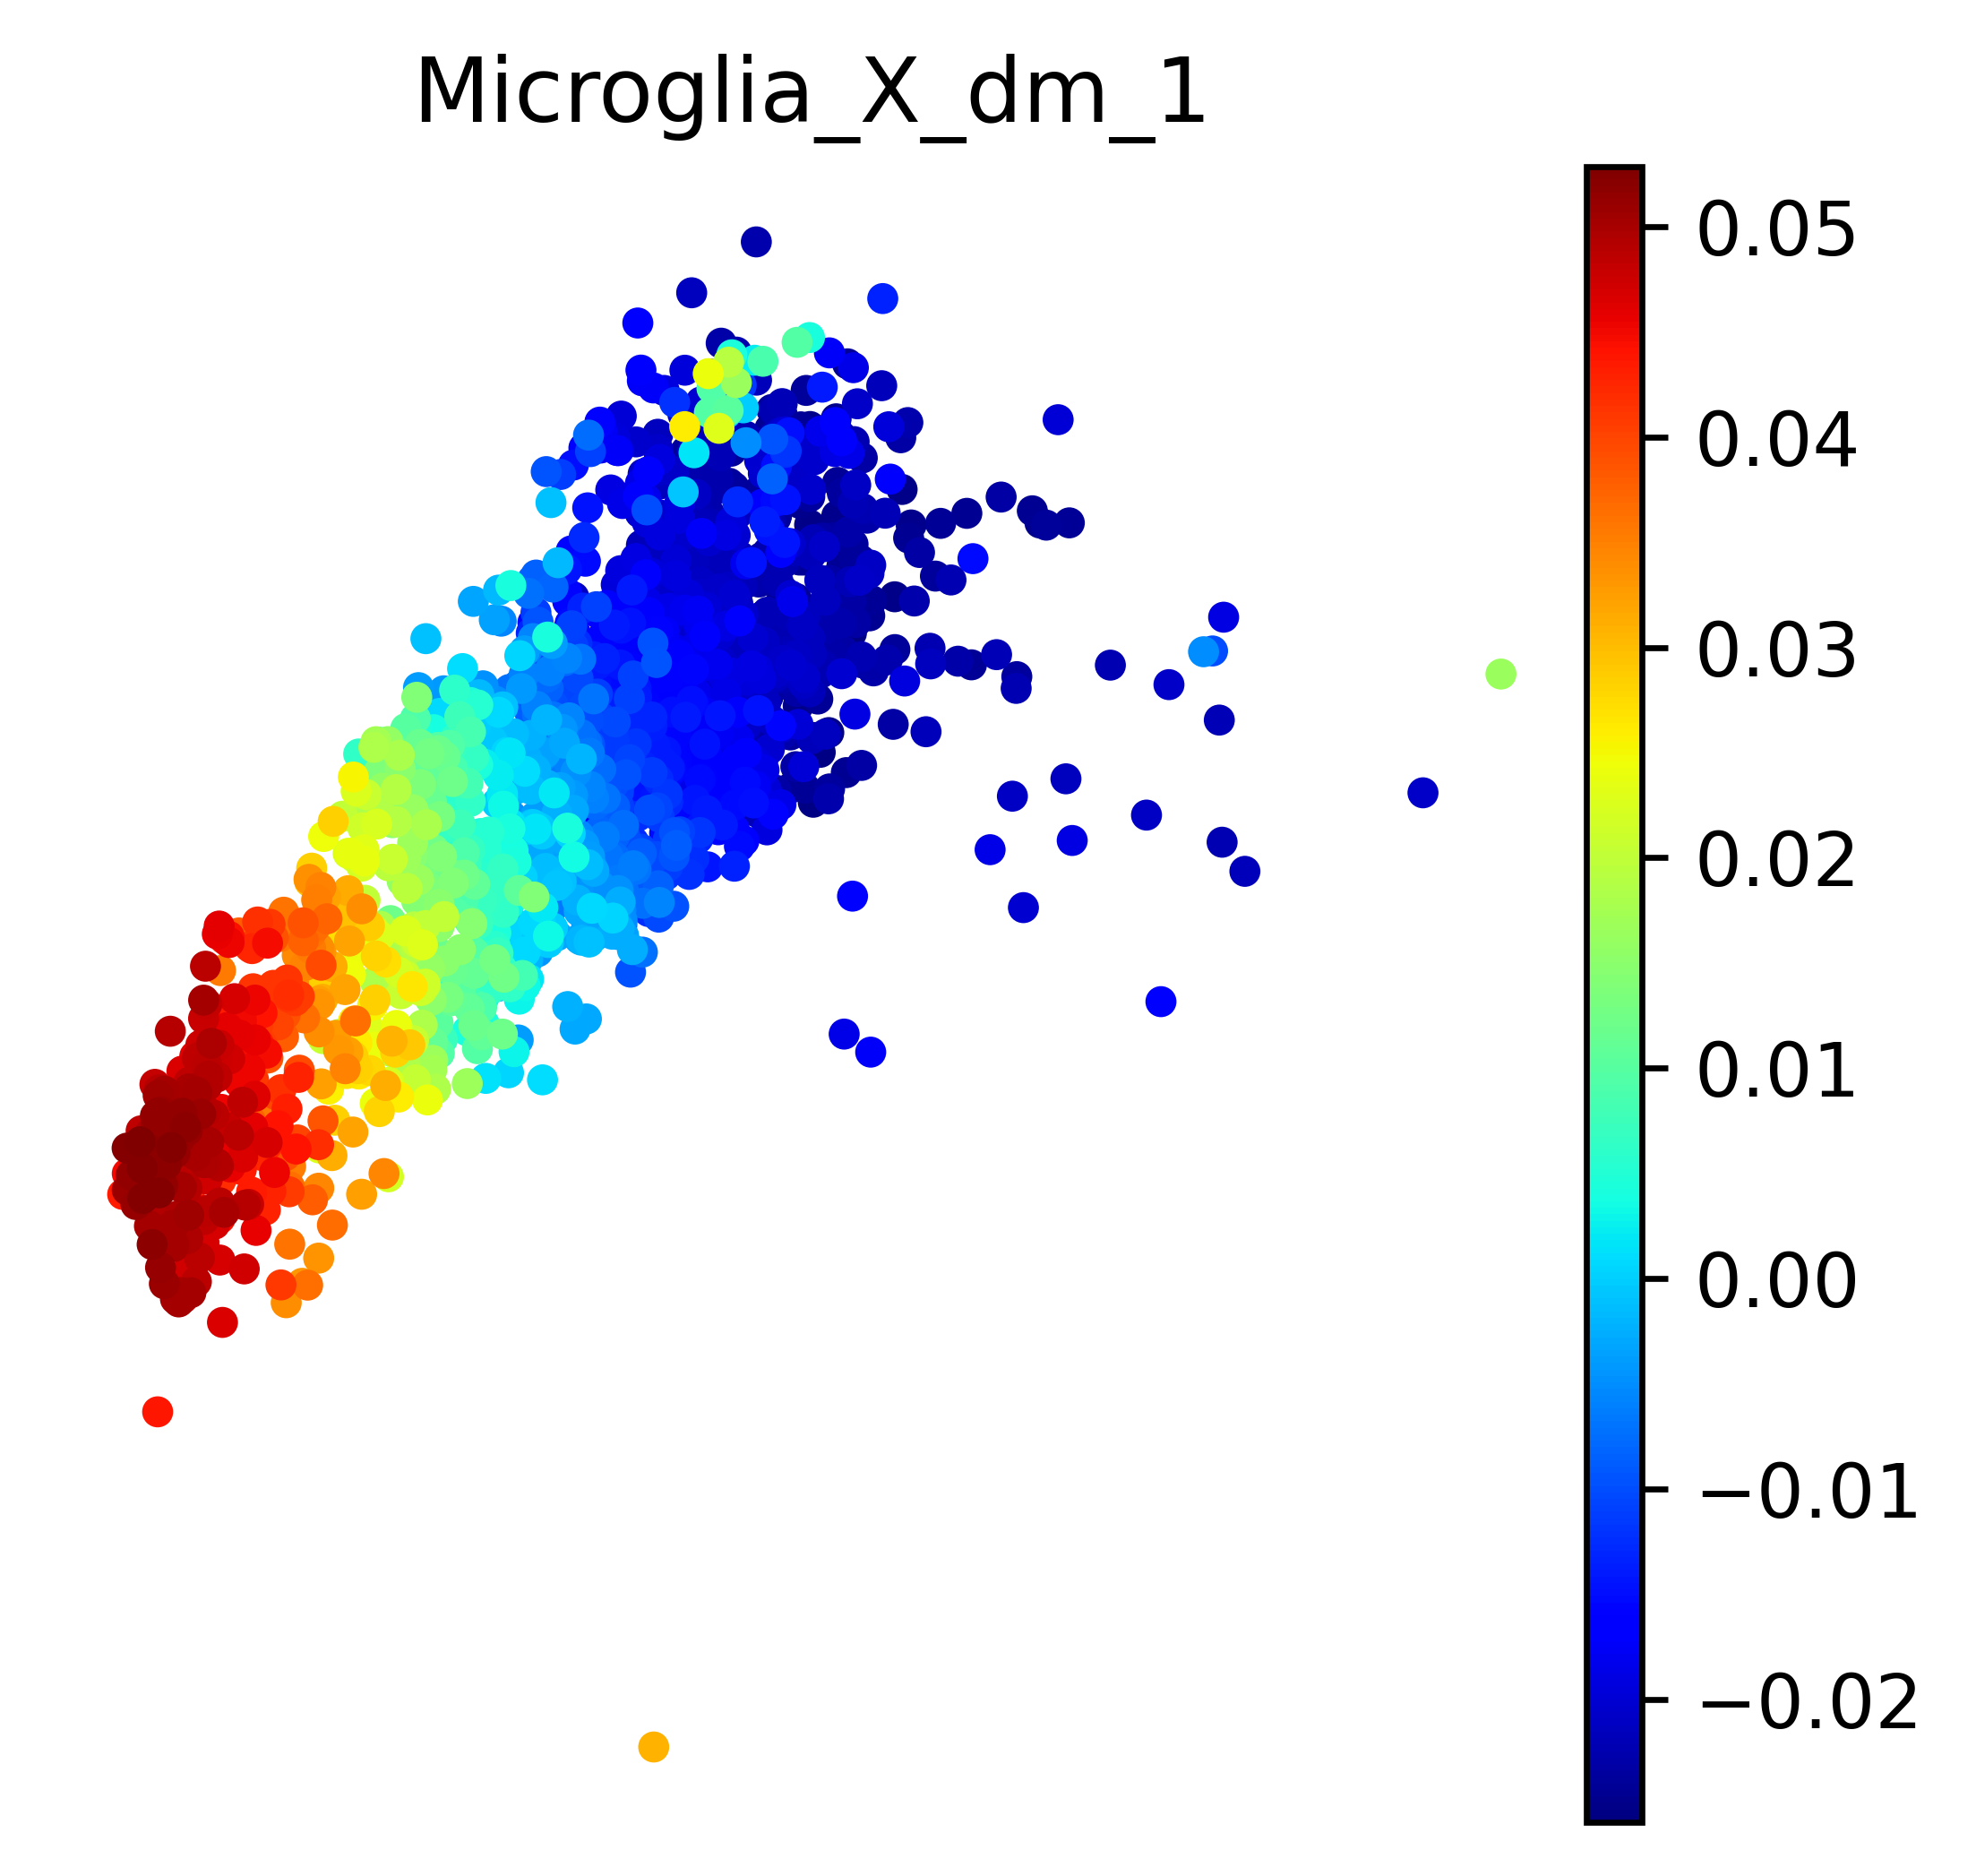

In [141]:
vis_rand = np.random.choice(range(adata.shape[0]),replace=False, size=adata.shape[0])

sc.pl.umap(adata[vis_rand], 
           color=['Microglia_X_dm_1'],
           cmap=plt.cm.jet,
           frameon=False)

## Examine gene expression trends


<b> Visualization functions adapted from Palantir (for convenience) </b>

In [142]:
# No further scaling (original pseudotime value)
class PResults_ori(object): 
    """
    Container of palantir results
    """

    def __init__(self, pseudotime, entropy, branch_probs, waypoints):

        # Initialize
        self._pseudotime = pseudotime 
        # - pseudotime.min()) / (
        # pseudotime.max() - pseudotime.min()
        # )
        self._entropy = entropy
        self._branch_probs = branch_probs
        self._branch_probs[self._branch_probs < 0.01] = 0
        self._waypoints = waypoints

    # Getters and setters
    @property
    def pseudotime(self):
        return self._pseudotime

    @property
    def branch_probs(self):
        return self._branch_probs

    @branch_probs.setter
    def branch_probs(self, branch_probs):
        self._branch_probs = branch_probs

    @property
    def entropy(self):
        return self._entropy

    @entropy.setter
    def entropy(self, entropy):
        self._entropy = entropy

    @property
    def waypoints(self):
        return self._waypoints

    @classmethod
    def load(cls, pkl_file):
        with open(pkl_file, "rb") as f:
            data = pickle.load(f)

        # Set up object
        presults = cls(
            data["_pseudotime"],
            data["_entropy"],
            data["_branch_probs"],
            data["_waypoints"],
        )
        return presults

In [143]:
def plot_gene_trend_heatmaps(gene_trends, vmin, vmax):
    """ Plot the gene trends on heatmap: a heatmap is generated or each branch
    :param: gene_trends: Results of the compute_marker_trends function
    """

    # Plot height
    branches = list(gene_trends.keys())
    genes = gene_trends[branches[0]]["trends"].index
    height = 0.7 * len(genes) * len(branches)

    #  Set up plot
    fig = plt.figure(figsize=[7, height])
    for i, branch in enumerate(branches):
        ax = fig.add_subplot(len(branches), 1, i + 1)

        # Standardize the matrix
        mat = gene_trends[branch]["trends"]
        mat = pd.DataFrame(
            StandardScaler().fit_transform(mat.T).T,
            index=[i.replace('nhood_', '').replace('_SCANPY_score','') for i in mat.index],
            columns=mat.columns,
        )
        sns.heatmap(mat, xticklabels=False, ax=ax, cmap=mpl.cm.Spectral_r,
                    vmin=vmin, vmax=vmax)
#         sns.clustermap(mat, xticklabels=False, ax=ax, cmap=mpl.cm.Spectral_r, vmin=vmin, vmax=vmax)
        ax.set_title(branch, fontsize=12)

In [144]:
# Neighborhood index cells
MG_idx = adata.obs_names[adata.obs['nhoodIdx']]

# Smallest & largest DC1 
# Note that here we switch min and max values to reverse the order of DC1
DC1_max = np.min(adata.obs['Microglia_X_dm_1'][MG_idx])
DC1_min = np.max(adata.obs['Microglia_X_dm_1'][MG_idx])

# DC_1 stretched to [0,1]
adata.obs['Microglia_X_dm_1_scaled'] = (adata.obs['Microglia_X_dm_1']-DC1_min)/(DC1_max-DC1_min)

# Given a single fate/lineage for the homeostasis-to-DAM transition, the branch_probs (probabilities for ...
# different fates/lineages) input to Palantir is set to 1 (binary constant data).

res = PResults_ori(pseudotime=adata.obs['Microglia_X_dm_1_scaled'],                 
                   branch_probs=pd.DataFrame(np.ones([len(MG_idx),1]),
                                             index=MG_idx,
                                             columns=['DAM']), 
                   entropy=pd.Series(np.zeros(len(MG_idx)),
                                     index=MG_idx),
                   waypoints=[])

<b> Signature scores along first diffusion component </b>

The following signatures are shown as example.

In [145]:
features = ['nhood_Amit_homeostatic_SCANPY_score',
    'TGFb_in_vivo_UP_SCANPY_score',
    'TNvsCtrl_logFC', 'HER2vsCtrl_logFC', #'TNvsHER2_logFC',
    'nhood_Disease-associated_MG_SCANPY_score',
    'nhood_Amit_stage 1 DAM_UP_SCANPY_score',
    'nhood_Amit_stage 2 DAM_SCANPY_score',
    'nhood_Actin_poly_depoly_score',
    'nhood_HALLMARK_OXIDATIVE_PHOSPHORYLATION_SCANPY_score',
    'nhood_HALLMARK_GLYCOLYSIS_SCANPY_score',]

values = adata[MG_idx].obs[features].copy()
values

,nhood_Amit_homeostatic_SCANPY_score,TGFb_in_vivo_UP_SCANPY_score,TNvsCtrl_logFC,HER2vsCtrl_logFC,nhood_Disease-associated_MG_SCANPY_score,nhood_Amit_stage 1 DAM_UP_SCANPY_score,nhood_Amit_stage 2 DAM_SCANPY_score,nhood_Actin_poly_depoly_score,nhood_HALLMARK_OXIDATIVE_PHOSPHORYLATION_SCANPY_score,nhood_HALLMARK_GLYCOLYSIS_SCANPY_score
SG-602_d27_inh_neg_169107449396019-0-1,1.391083,0.664026,3.318817,3.768108,1.109694,1.934806,0.431408,0.231364,0.484147,0.099125
SG-602_d27_inh_neg_130673819466478-0-1,2.164232,1.151333,0.928407,1.890090,1.123365,2.208156,0.373903,0.197160,0.391648,0.044443
SG-602_d27_inh_mCh_230816753015667-1-1,0.600960,0.412494,1.970065,6.045229,1.371129,2.196098,0.723281,0.255652,0.653394,0.136374
SG-602_d27_inh_mCh_226764285697389-1-1,1.256379,0.677703,4.581153,6.052220,1.325776,2.142622,0.664248,0.245948,0.607471,0.116106
SG-602_d27_inh_mCh_134393214979310-1-1,1.144381,0.752083,2.958715,5.257140,1.261310,2.234499,0.616092,0.249972,0.690202,0.112745
...,...,...,...,...,...,...,...,...,...,...
SG-602_d27_inh_mCh_164698921000357-1-1,3.208632,1.333858,0.519778,0.438527,0.479035,1.125659,-0.337328,0.182146,0.228140,0.017370
SG-602_d27_inh_mCh_134585682615589-1-1,2.985527,1.132853,0.588477,0.344954,0.568276,1.098915,-0.254116,0.185010,0.224590,0.013853
SG-602_d27_inh_mCh_157148381133043-1-1,3.208780,1.138527,0.146911,-0.002073,0.397256,0.975608,-0.434724,0.176571,0.198050,0.014049
SG-602_d27_inh_mCh_125168073750254-1-1,3.233752,1.218085,-0.076937,0.624738,0.492828,0.987554,-0.307101,0.170382,0.200243,0.017777


In [146]:
feature_trends = pl.presults.compute_gene_trends(res, values) 

DAM
Time for processing DAM: 0.3465888222058614 minutes


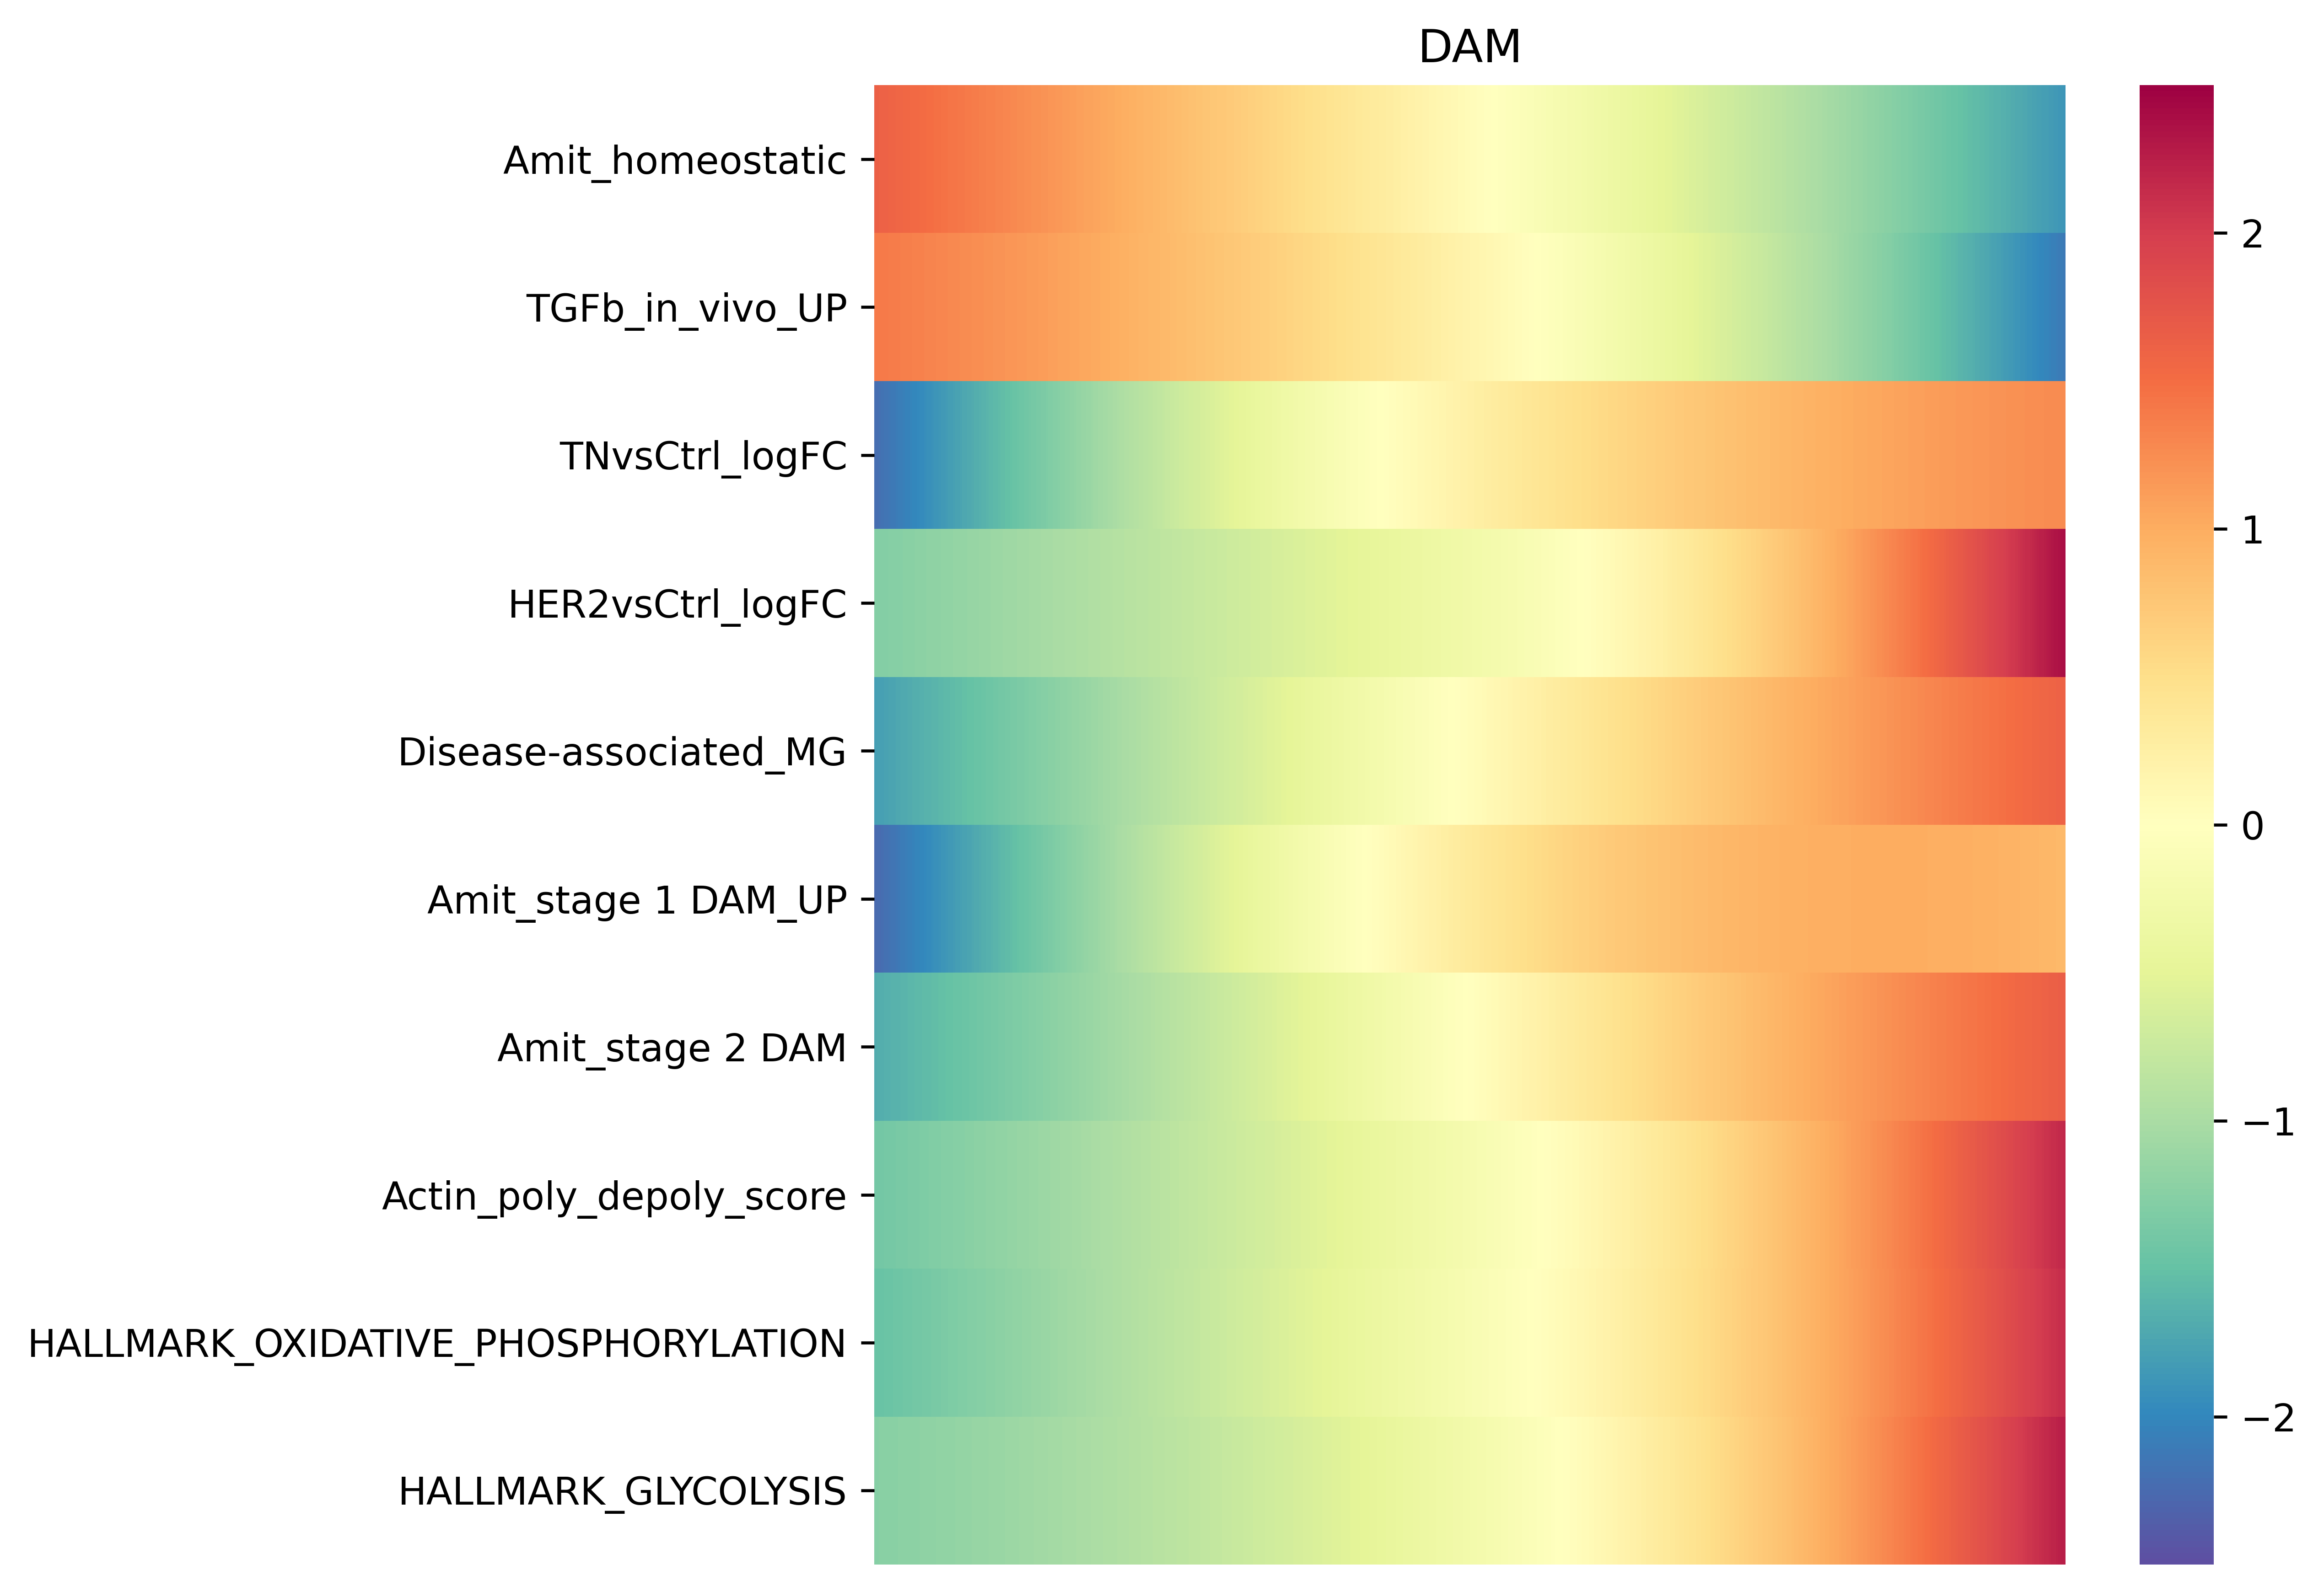

In [147]:
mpl.rcParams['figure.figsize'] = [4,10]
plot_gene_trend_heatmaps(feature_trends, vmin=-2.5, vmax=2.5)

<b> Gene expression along first diffusion component </b>

The following genes are shown as example.

In [152]:
# Stage 2 DAM markers
features = ['nhood_Amit_stage 2 DAM_SCANPY_score',
            'nhood_CSF1',
            'nhood_CCL6',
            'nhood_AXL',
            'nhood_SPP1',
            'nhood_CD9',
            'nhood_CST7',
            'nhood_ITGAX',
            'nhood_LPL',]

values = adata[MG_idx].obs[features].copy()
values

,nhood_Amit_stage 2 DAM_SCANPY_score,nhood_CSF1,nhood_CCL6,nhood_AXL,nhood_SPP1,nhood_CD9,nhood_CST7,nhood_ITGAX,nhood_LPL
SG-602_d27_inh_neg_169107449396019-0-1,0.431408,0.315006,0.842605,1.560122,3.585303,2.729767,1.188233,0.382861,0.500638
SG-602_d27_inh_neg_130673819466478-0-1,0.373903,0.361693,0.891527,1.291929,1.838353,3.163139,1.651965,0.700190,0.321340
SG-602_d27_inh_mCh_230816753015667-1-1,0.723281,0.377927,0.576117,1.582166,4.613489,3.264679,1.848447,0.741655,0.576741
SG-602_d27_inh_mCh_226764285697389-1-1,0.664248,0.279869,1.028182,1.784887,3.468926,3.364767,2.175592,0.854159,0.458740
SG-602_d27_inh_mCh_134393214979310-1-1,0.616092,0.242319,1.051617,1.113396,4.541395,3.199864,1.824393,0.333505,0.539928
...,...,...,...,...,...,...,...,...,...
SG-602_d27_inh_mCh_164698921000357-1-1,-0.337328,0.066492,0.480082,0.196723,0.213113,2.394642,0.257742,0.067101,0.018098
SG-602_d27_inh_mCh_134585682615589-1-1,-0.254116,0.163814,0.627816,0.270221,0.354991,2.471311,0.326781,0.081164,0.104357
SG-602_d27_inh_mCh_157148381133043-1-1,-0.434724,0.107990,0.315646,0.109344,0.037446,1.993060,0.094911,0.005258,0.010568
SG-602_d27_inh_mCh_125168073750254-1-1,-0.307101,0.115226,0.445090,0.180336,0.203984,2.514587,0.230946,0.082554,0.010679


In [153]:
feature_trends = pl.presults.compute_gene_trends(res, values) 

DAM
Time for processing DAM: 0.28339895407358806 minutes


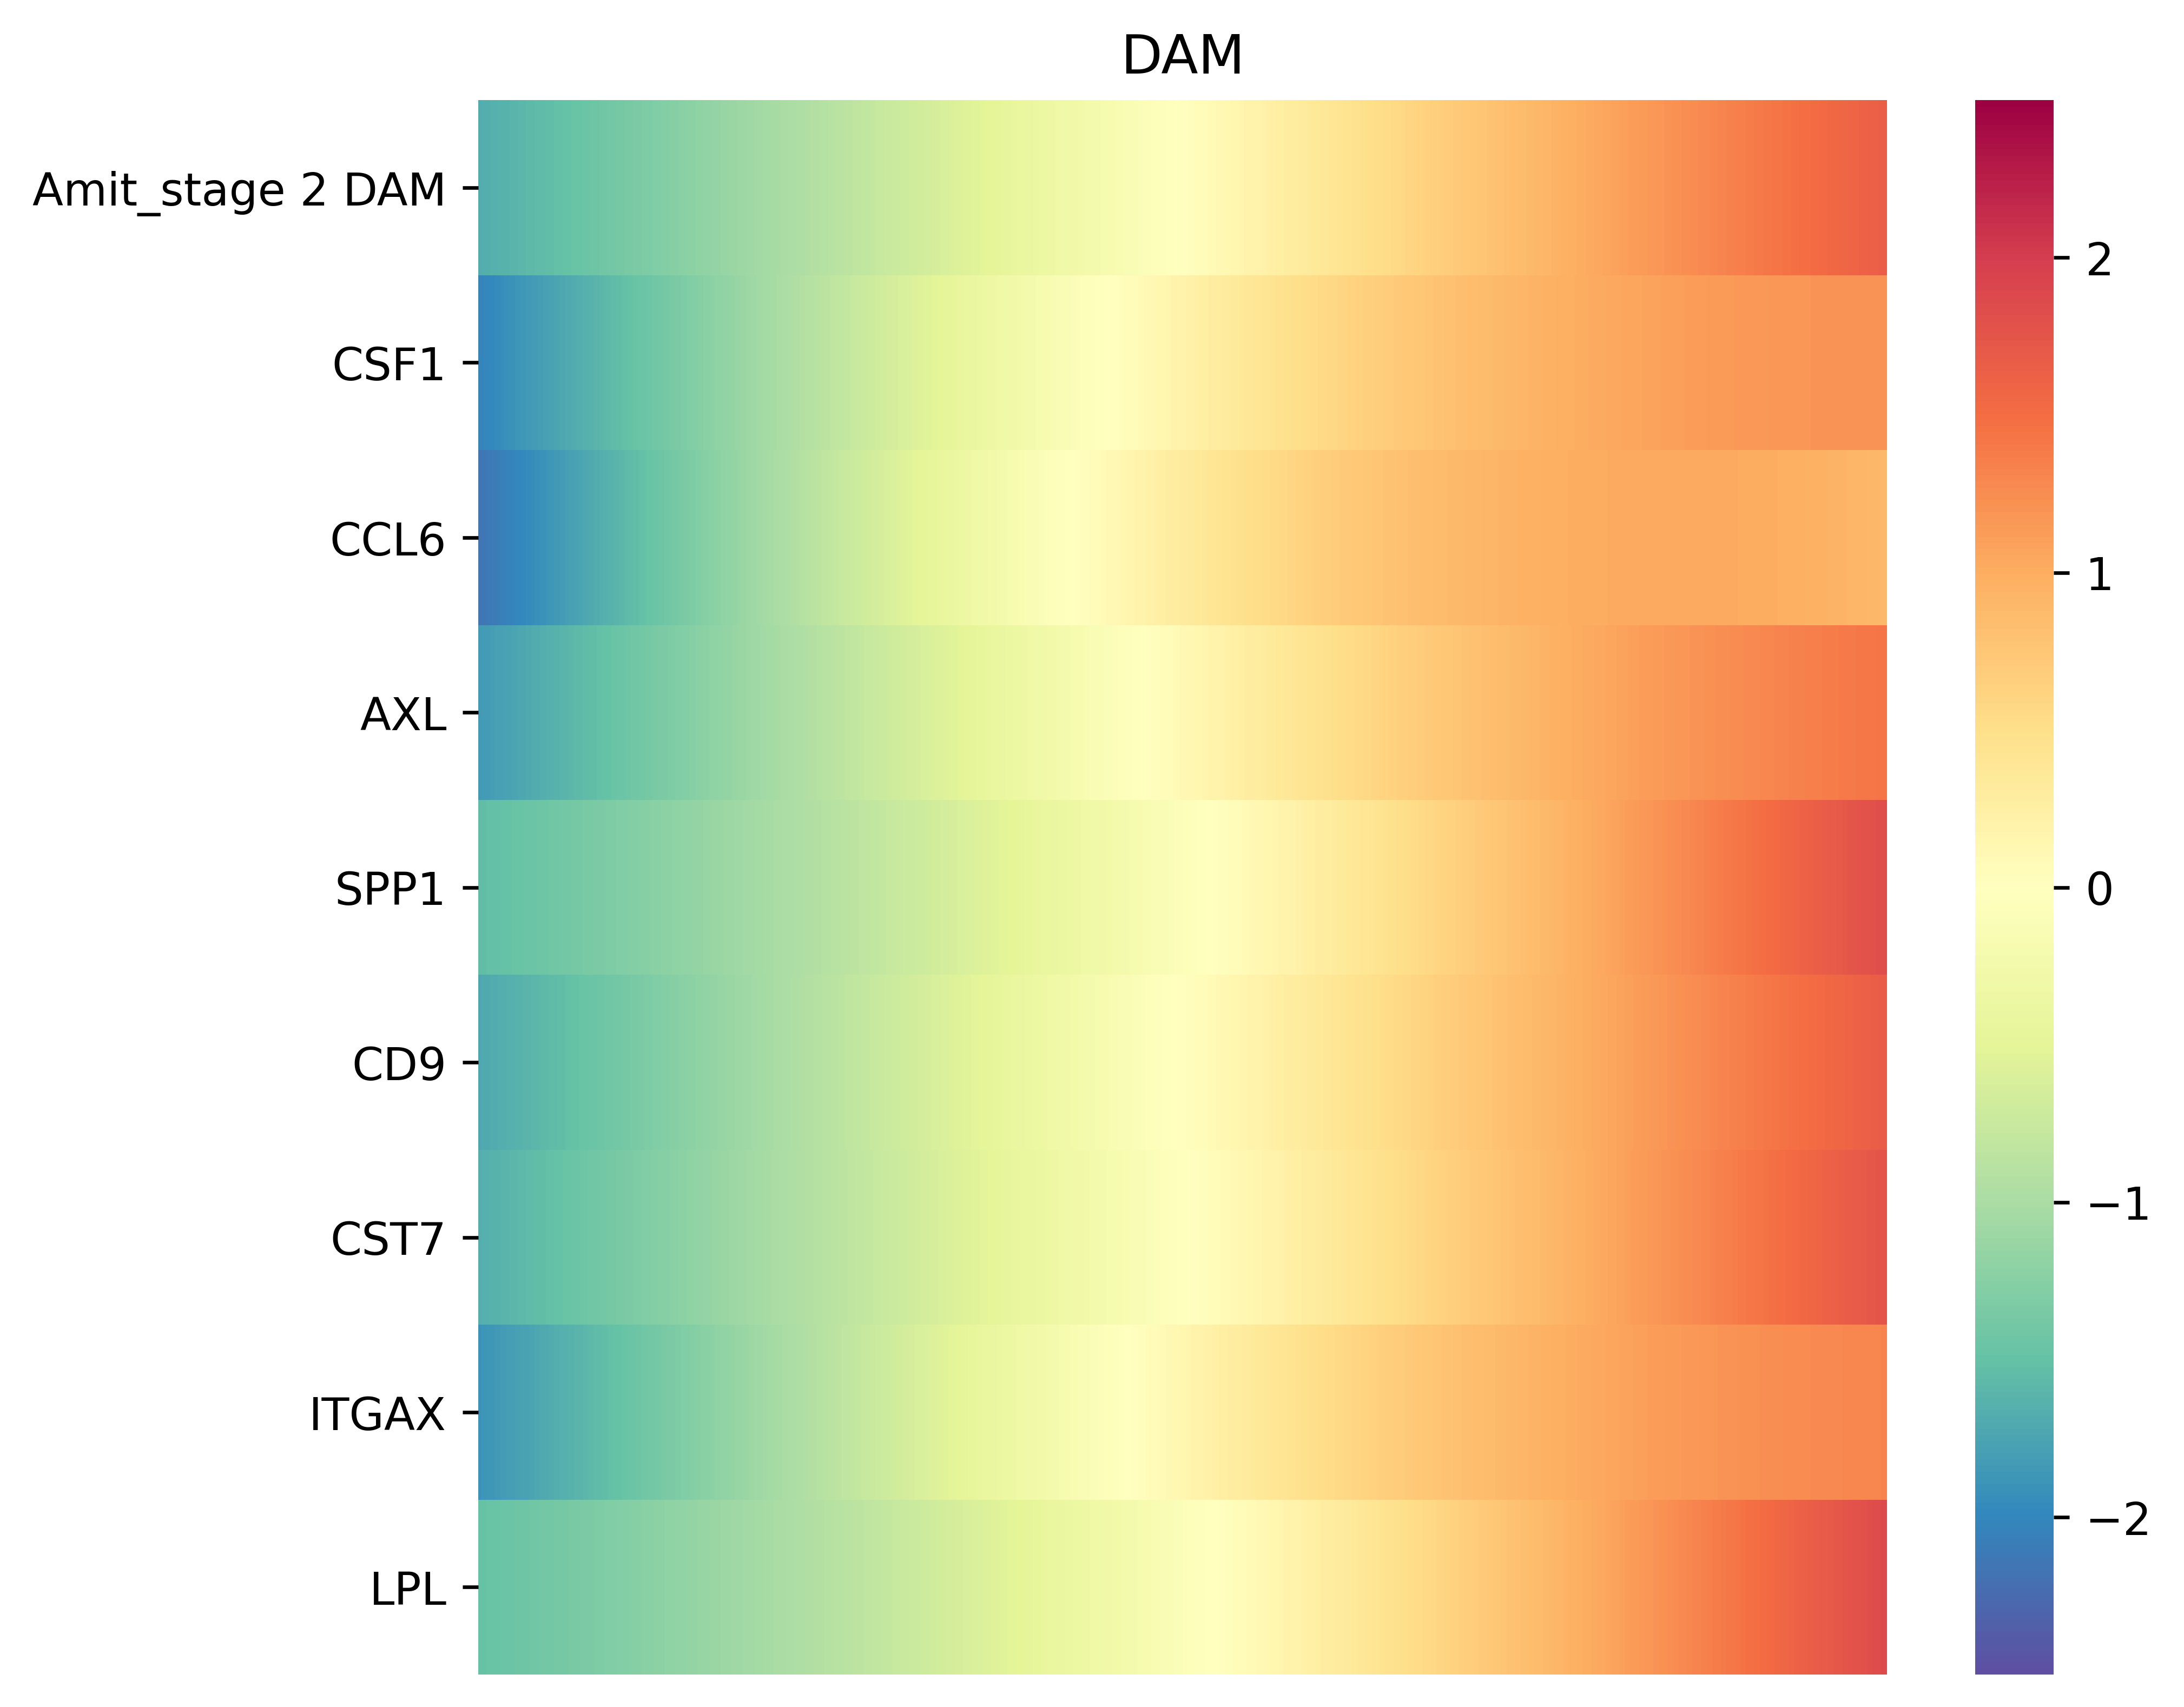

In [154]:
mpl.rcParams['figure.figsize'] = [4,10]
plot_gene_trend_heatmaps(feature_trends, vmin=-2.5, vmax=2.5)

## Examine Type I interferon  (IFN) response

<b> Finalized PhenoGraph clustering </b>

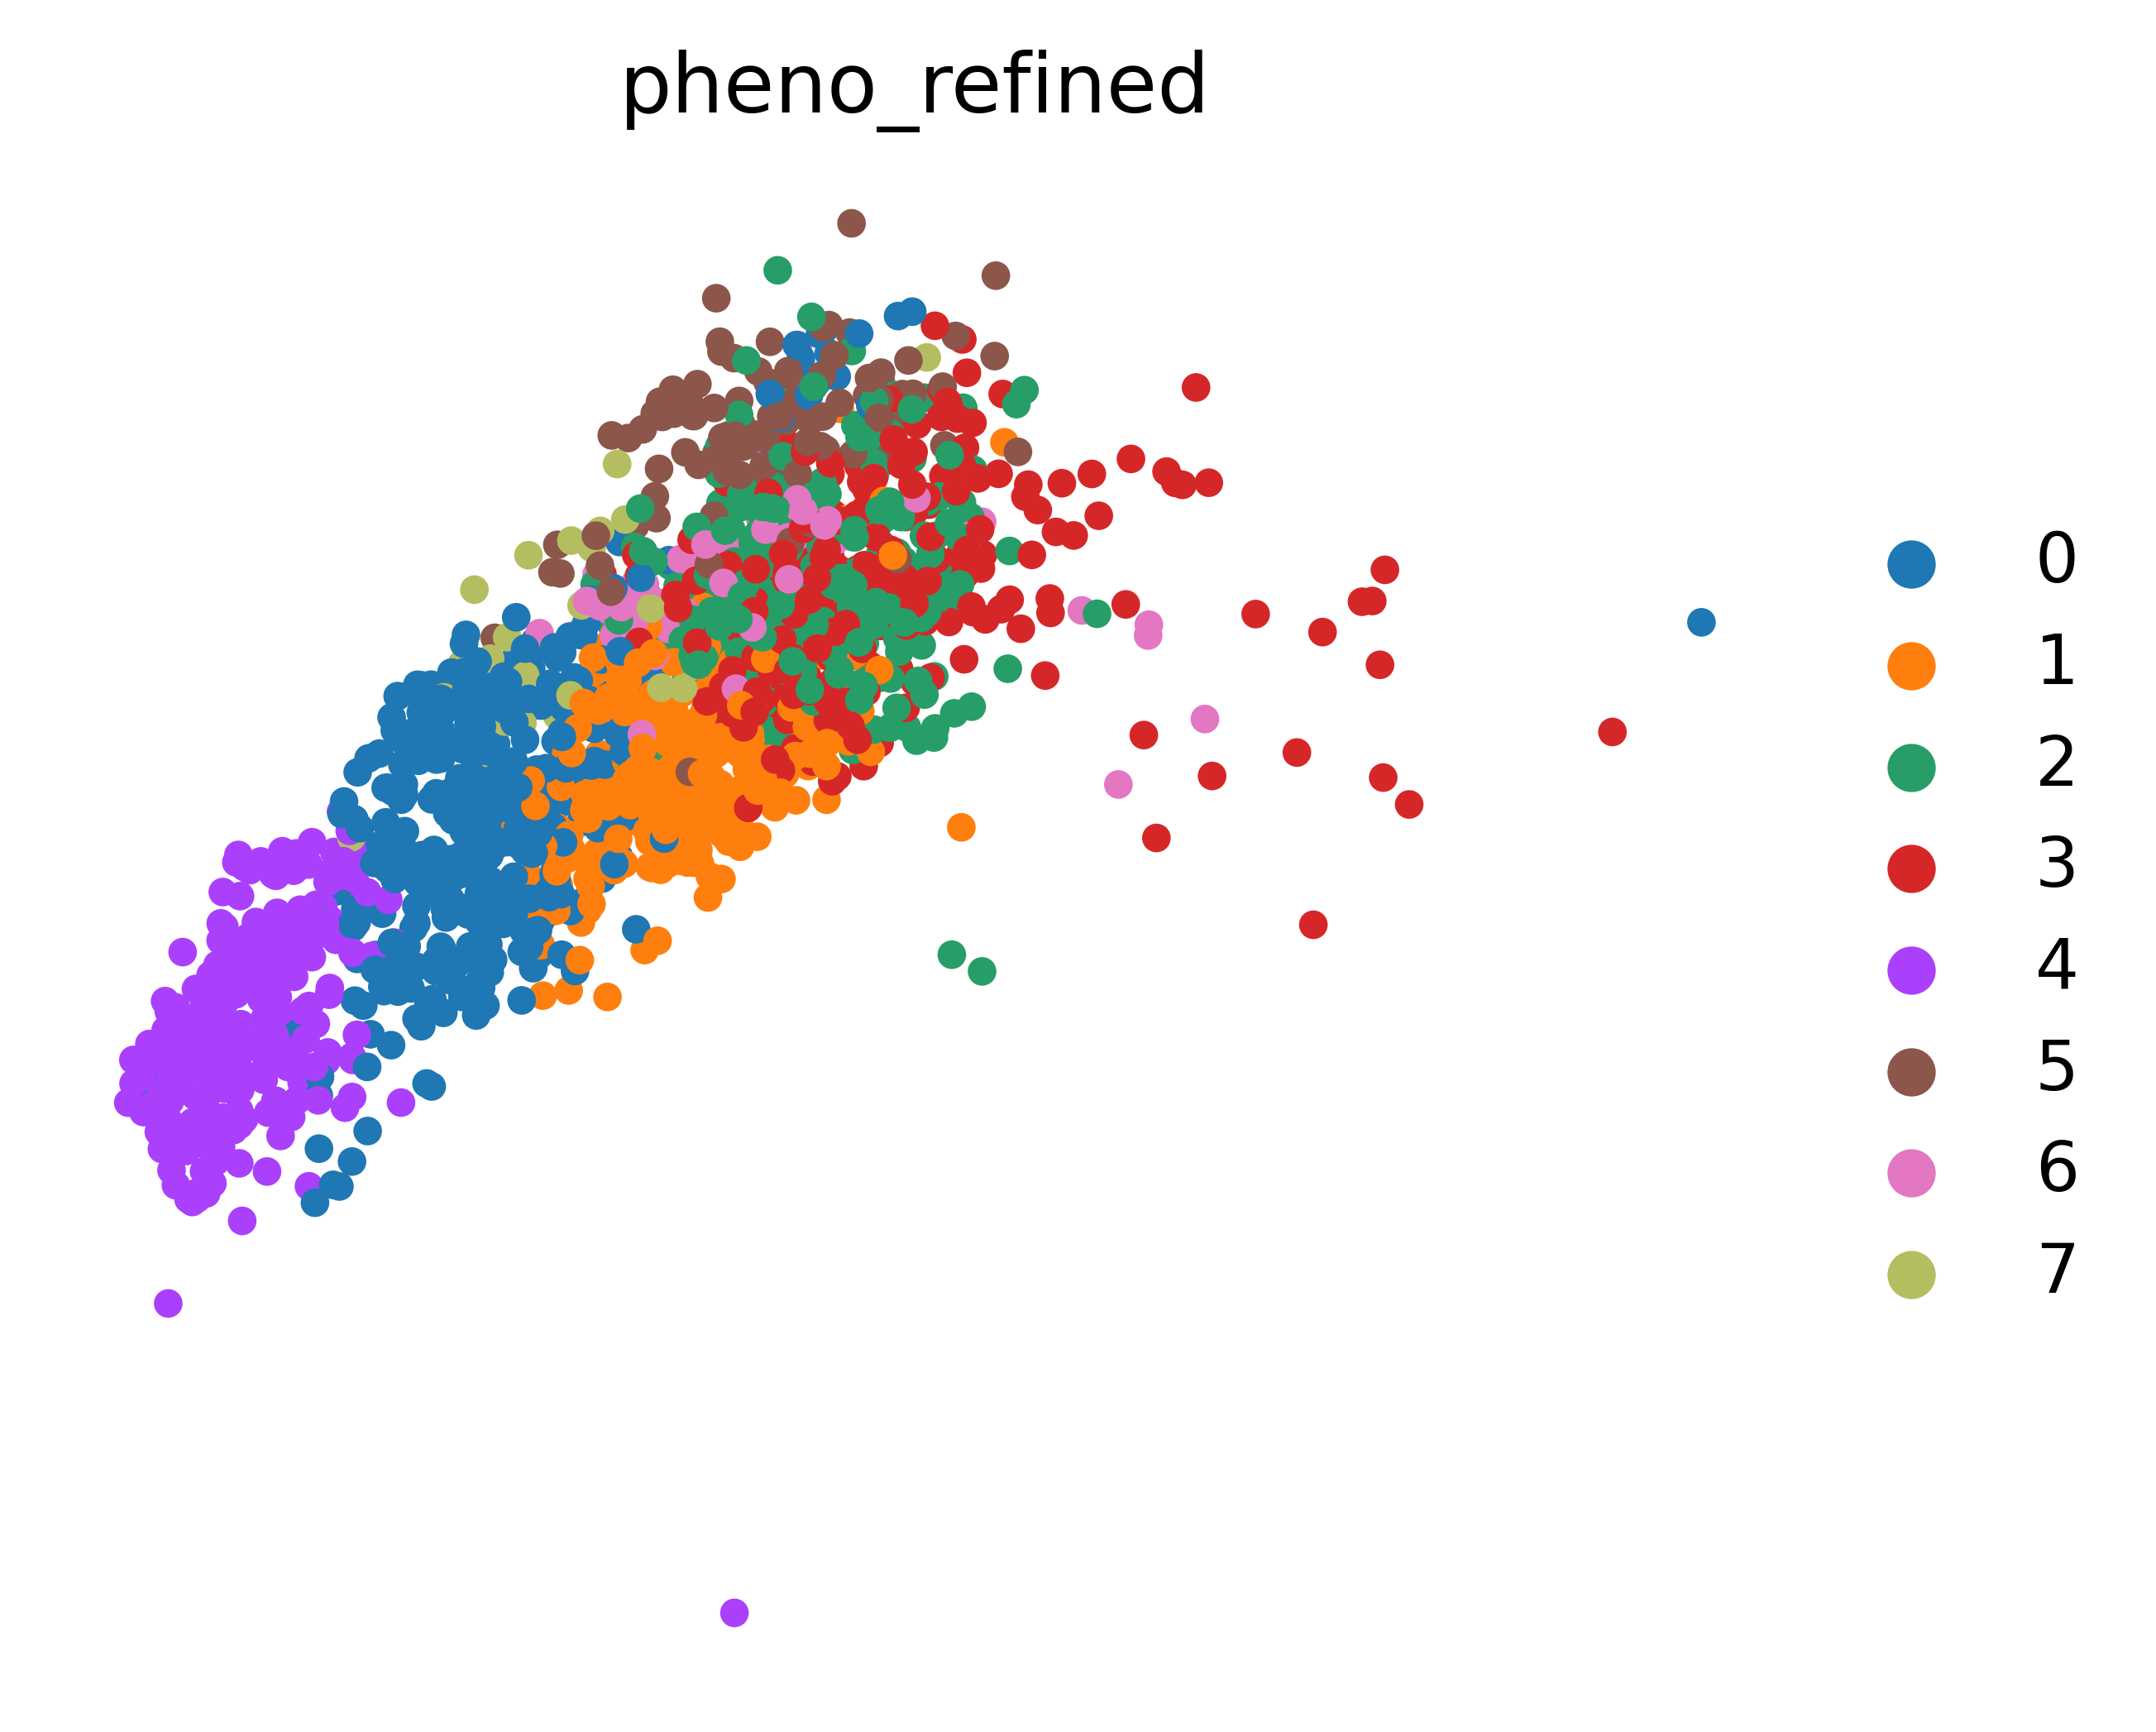

In [155]:
mpl.rcParams['figure.figsize'] = [4.5,4]

vis_rand = np.random.choice(range(adata.shape[0]),replace=False, size=adata.shape[0])

sc.pl.umap(adata[vis_rand], 
           color=['pheno_refined'],
           frameon=False)

<b> Type I IFN response </b>


Matrixplot functio in Scanpy takes variables (and not genes) as input, so need to perform the following steps to achieve the visualization using matrixplot.

In [156]:
# Put genes into temp1
temp1 = pd.DataFrame(adata[:,['AXL']].X,
                     index=adata.obs_names, 
                     columns=['AXL']) 

In [157]:
# Put vars into temp2
temp2 = pd.DataFrame(adata.obs[['Amit_homeostatic_SCANPY_score',
                                'Disease-associated_MG_SCANPY_score',
                                'Amit_stage 1 DAM_UP_SCANPY_score',
                                'Amit_stage 2 DAM_SCANPY_score',
                                'Annotated_TypeI_IFN_score',
                                'Microglia_X_dm_1']],
                     columns=['Amit_homeostatic_SCANPY_score',
                              'Disease-associated_MG_SCANPY_score',
                              'Amit_stage 1 DAM_UP_SCANPY_score',
                              'Amit_stage 2 DAM_SCANPY_score',
                              'Annotated_TypeI_IFN_score',
                              'Microglia_X_dm_1'])

In [158]:
temp = sc.AnnData(X=pd.concat([temp1, temp2], axis=1))
temp.obs[['pheno_refined']] = adata.obs[['pheno_refined']].copy()

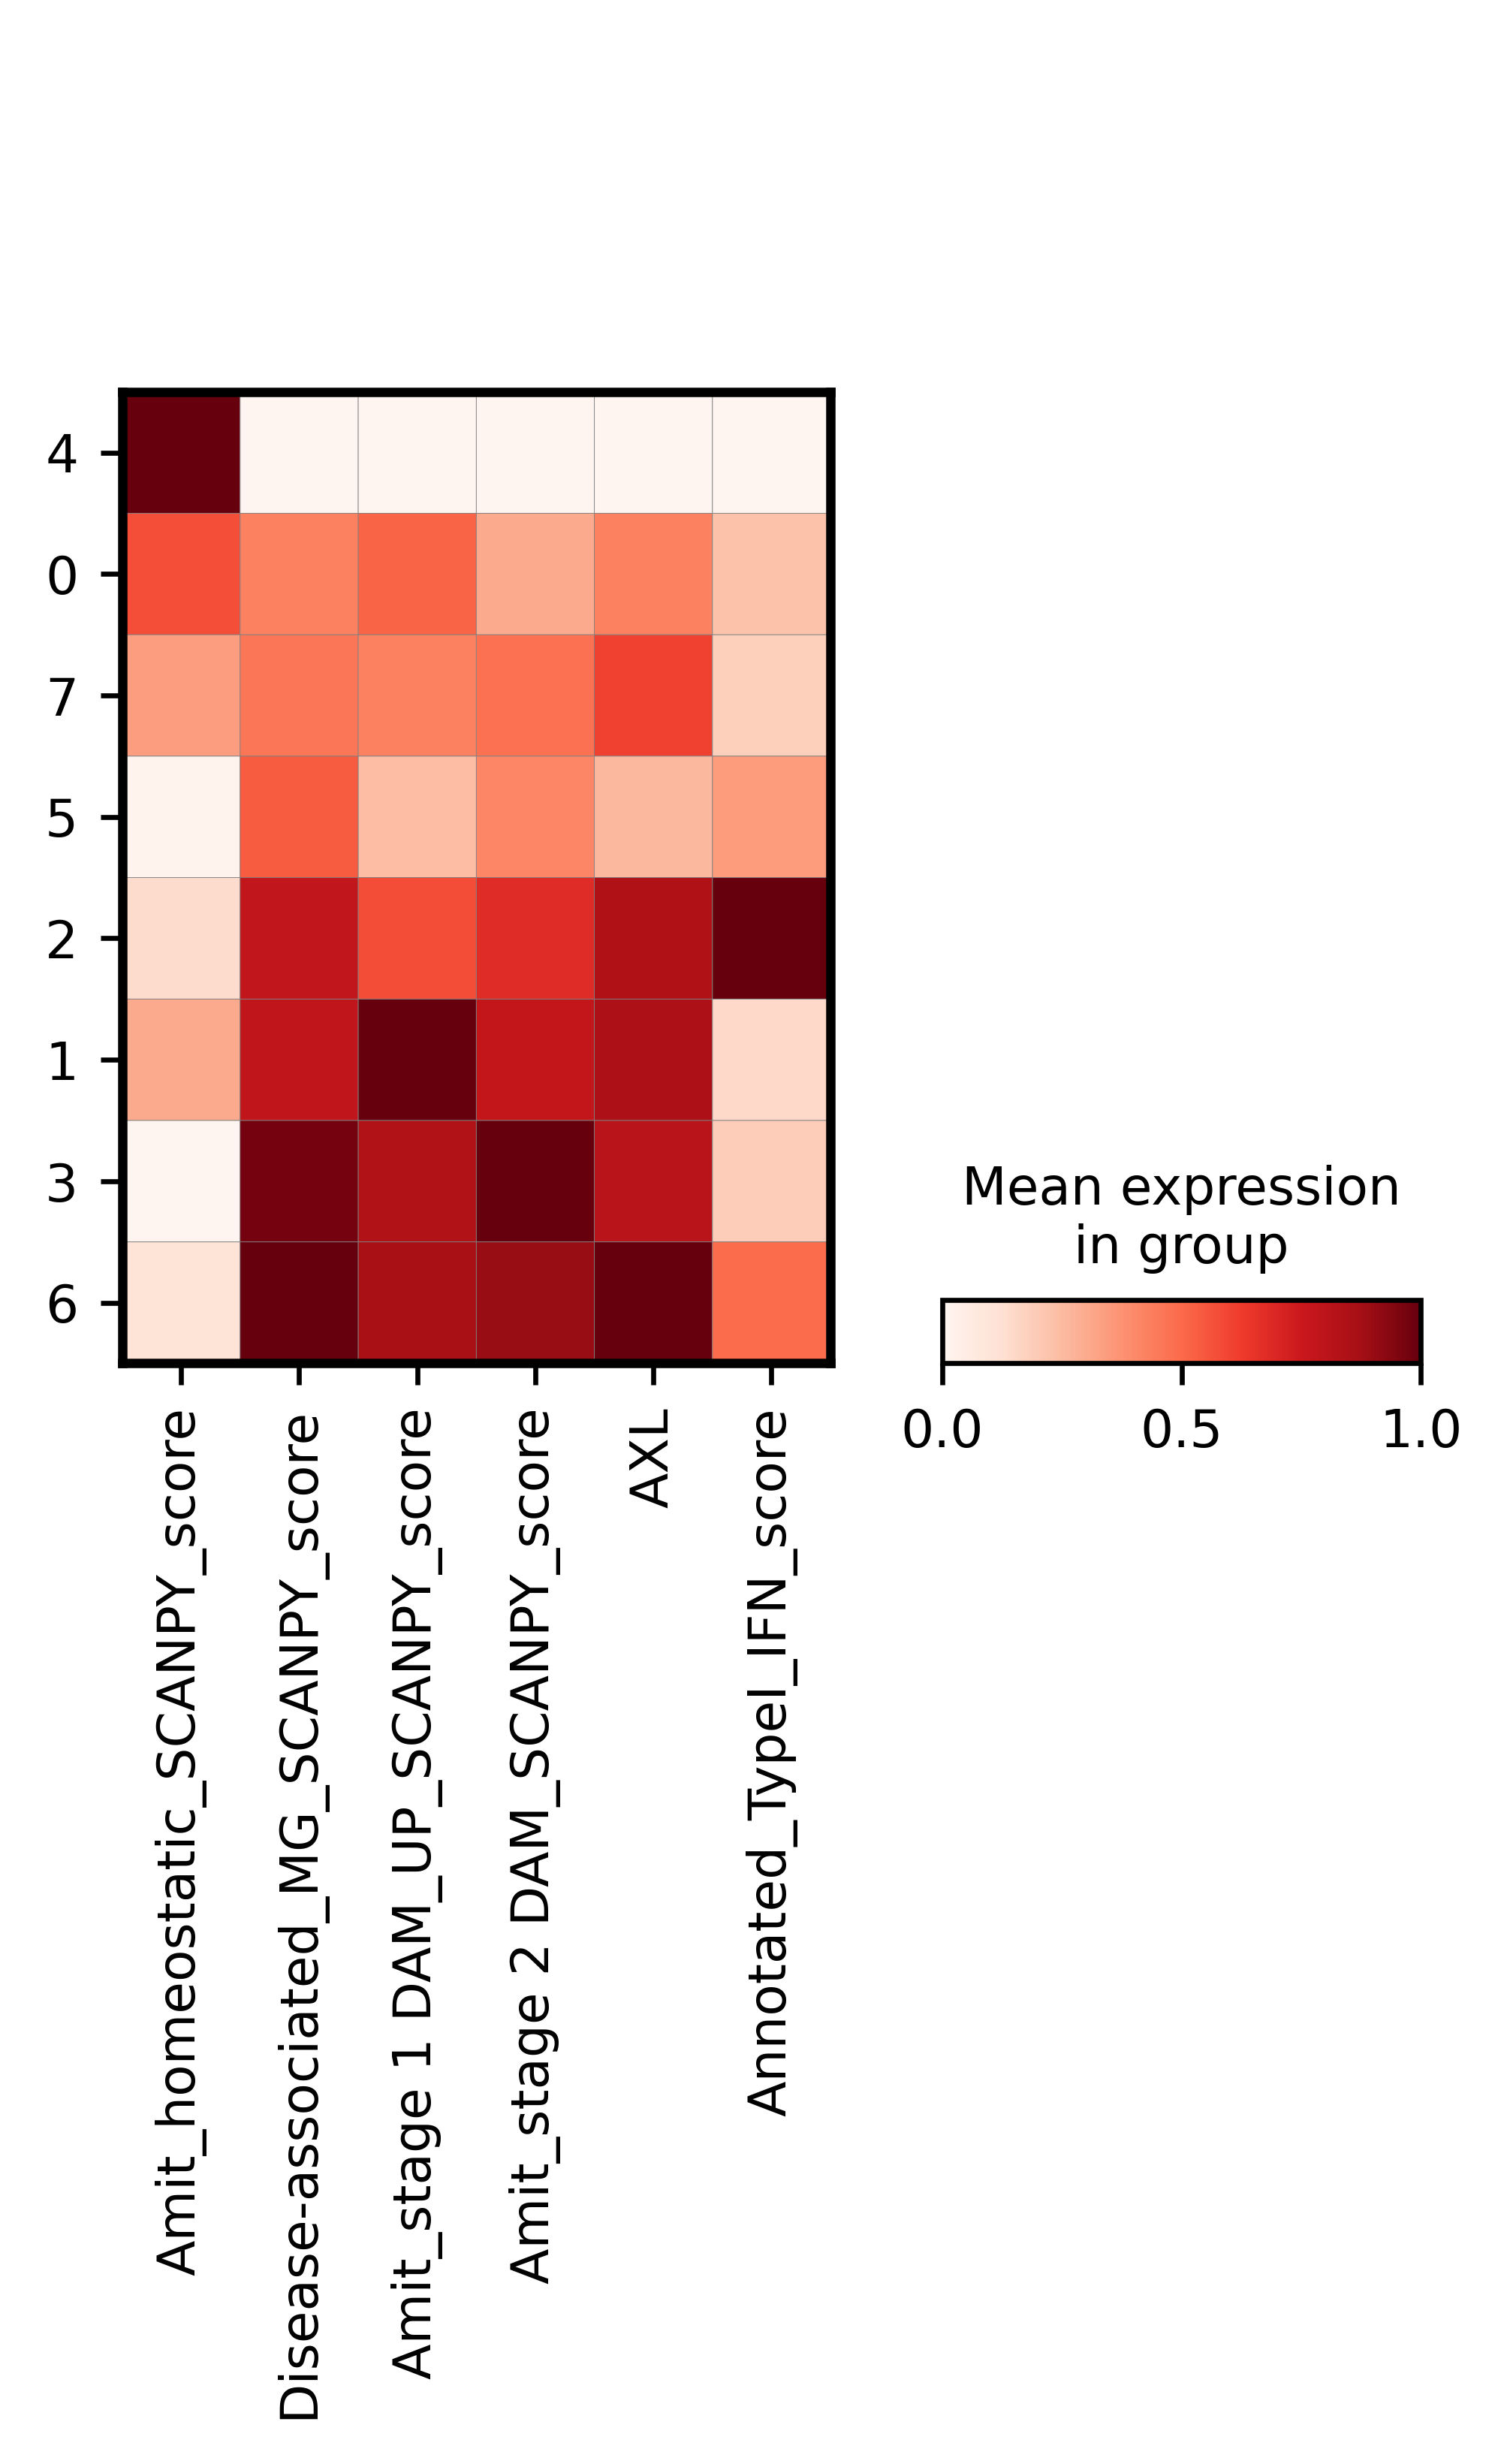

In [159]:
ax = sc.pl.matrixplot(temp, ['Amit_homeostatic_SCANPY_score',
                             'Disease-associated_MG_SCANPY_score',
                             'Amit_stage 1 DAM_UP_SCANPY_score',
                             'Amit_stage 2 DAM_SCANPY_score',
                             'AXL',
                             'Annotated_TypeI_IFN_score',
                            ], 
                      categories_order = [4,0,7,5,2,1,3,6], # Along increasing DAM scores
                      groupby='pheno_refined', 
                      standard_scale='var', cmap='Reds')

# Save results

In [160]:
# Save udpated adata to the original directory
for h5_file in Path(DATA_DIR+source).glob('*.h5'):   
    adata.write(h5_file)